# GAN example

In [1]:
# import necessary packages

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

In [2]:
noise_dim = 100 
fs = 8

In [4]:
# creating the dataset of real images
size = 32

def create_images_vert(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(10):
            x0 = random.randrange(5,size-5)
            sample = cv2.line(sample,(x0,0),(x0,size-1),(255,255,255),1)
#         sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
#         sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def create_images_diag(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(3):
            x0 = random.randrange(-size/2,size/2)
            sample = cv2.line(sample,(x0,0),(x0+32,32),(255,255,255),2)
        sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
        sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def load_images(dir):
    samples = []
    for image_file in os.listdir(dir):
        if image_file.endswith("jpg"):
            sample = cv2.imread(f"{dir}/{image_file}")
            sample = cv2.resize(sample, (32,32))
            sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
            sample = np.expand_dims(sample,axis=2)
            samples.append(sample)
    return samples

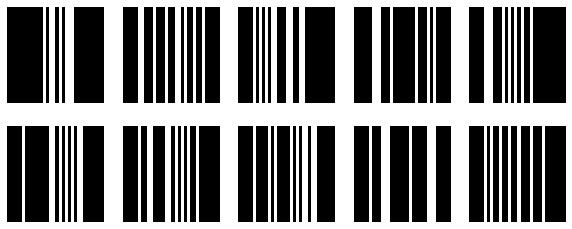

In [5]:
#samples = create_images_diag(1000)
samples = create_images_vert(1000)
#samples = load_images('signs')
samples = np.array(samples)
samples = samples/255

plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i][:,:,0],cmap='gray')
    #plt.title(labels[i])
    plt.axis("off")

In [7]:
# Generator gets a noise vector of size noise_dim and generates an image of size (32 x 32 x 1)
# Our aim: we want the image to be as similar to real images (generated above) as possible
def make_generator_model():
    model = Sequential()
    model.add(Dense(8*8*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) 
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 8 x 8 x 128

    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 16 x 16 x 64

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    # output: 32 x 32 x 1 (our image)

    model.summary()
    return model

generator = make_generator_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

In [8]:
# Discriminator gets image of size (32 x 32 x 1) and decides if it is real or fake
# The result of the discriminator is used by generator to improve 'faking'

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    # output: one number 0-fake, 1-real
    model.summary()

    return model

discriminator = make_discriminator_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [9]:
# returns randomly choosen n real samples

def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
    new_samples = np.array(new_samples,dtype=float)    

    return new_samples

In [10]:
# training parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.BinaryCrossentropy()


In [12]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct: 
        if x>=0.5: 
            ok+=1 
    return ok

# The training step

history = []
##@tf.function
def do_step(images):
    batch_size = len(images)
    images = np.array(images)
    # create random noise for generator
    input_noise = randn(batch_size * noise_dim)
    input_noise = input_noise.reshape(batch_size, noise_dim)
    input_noise = tf.convert_to_tensor(input_noise)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake image using noise
        generated_images = generator(input_noise, training=True)
        # evaluate fake images
        fake_output = discriminator(generated_images, training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        # generator wants all images to be accepted (output=1)!
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        # evaluate real images
        real_output = discriminator(images, training=True)
        real_acc = calc_ok(real_output)/batch_size
        # discriminator wants to classify all real images as 1 and fake images as 0
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = (real_loss + fake_loss)/2 # sum up both losses

    # calculate how to change generator to minimze its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # calculate how to change discriminator to minimze its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # update weights for both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    print(f"Epoch {epoch} gen_loss={gen_loss.numpy():.3f} disc_loss={disc_loss.numpy():.3f} real_acc={real_acc} fake_acc={fake_acc}")

    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])
    

In [13]:
def show_results(epoch):
    # show one real image and some fake images generated by generator using noise seed
    num_examples_to_generate = 6
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    predictions = generator(seed, training=False)
    fig = plt.figure(figsize=(10,10))
    r = random.randrange(len(samples))
    plt.subplot(1, num_examples_to_generate+1, 1)
    #plt.imshow(samples[r, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.imshow(samples[r, :, :, 0], cmap='gray')
    plt.axis('off')
    for i in range(predictions.shape[0]):
        plt.subplot(1, num_examples_to_generate+1, i+2)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()    


Epoch 0 gen_loss=0.723 disc_loss=0.688 real_acc=0.28 fake_acc=0.86


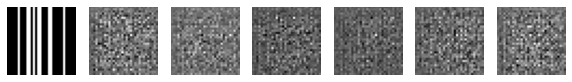

Epoch 1 gen_loss=0.739 disc_loss=0.685 real_acc=0.2 fake_acc=0.94
Epoch 2 gen_loss=0.759 disc_loss=0.680 real_acc=0.18 fake_acc=1.0
Epoch 3 gen_loss=0.777 disc_loss=0.676 real_acc=0.1 fake_acc=1.0
Epoch 4 gen_loss=0.804 disc_loss=0.658 real_acc=0.26 fake_acc=1.0
Epoch 5 gen_loss=0.811 disc_loss=0.660 real_acc=0.16 fake_acc=1.0
Epoch 6 gen_loss=0.836 disc_loss=0.647 real_acc=0.22 fake_acc=1.0
Epoch 7 gen_loss=0.853 disc_loss=0.639 real_acc=0.2 fake_acc=1.0
Epoch 8 gen_loss=0.867 disc_loss=0.635 real_acc=0.2 fake_acc=1.0
Epoch 9 gen_loss=0.886 disc_loss=0.624 real_acc=0.32 fake_acc=1.0
Epoch 10 gen_loss=0.898 disc_loss=0.621 real_acc=0.3 fake_acc=1.0


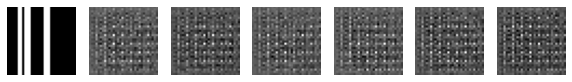

Epoch 11 gen_loss=0.921 disc_loss=0.612 real_acc=0.32 fake_acc=1.0
Epoch 12 gen_loss=0.938 disc_loss=0.601 real_acc=0.4 fake_acc=1.0
Epoch 13 gen_loss=0.949 disc_loss=0.598 real_acc=0.42 fake_acc=1.0
Epoch 14 gen_loss=0.967 disc_loss=0.592 real_acc=0.42 fake_acc=1.0
Epoch 15 gen_loss=0.971 disc_loss=0.581 real_acc=0.62 fake_acc=1.0
Epoch 16 gen_loss=0.979 disc_loss=0.575 real_acc=0.66 fake_acc=1.0
Epoch 17 gen_loss=1.001 disc_loss=0.568 real_acc=0.64 fake_acc=1.0
Epoch 18 gen_loss=1.028 disc_loss=0.554 real_acc=0.66 fake_acc=1.0
Epoch 19 gen_loss=1.026 disc_loss=0.547 real_acc=0.8 fake_acc=1.0
Epoch 20 gen_loss=1.031 disc_loss=0.546 real_acc=0.76 fake_acc=1.0


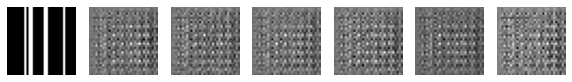

Epoch 21 gen_loss=1.033 disc_loss=0.528 real_acc=0.94 fake_acc=1.0
Epoch 22 gen_loss=1.050 disc_loss=0.523 real_acc=0.94 fake_acc=1.0
Epoch 23 gen_loss=1.043 disc_loss=0.525 real_acc=0.92 fake_acc=1.0
Epoch 24 gen_loss=1.053 disc_loss=0.501 real_acc=0.98 fake_acc=1.0
Epoch 25 gen_loss=1.046 disc_loss=0.498 real_acc=1.0 fake_acc=1.0
Epoch 26 gen_loss=1.045 disc_loss=0.501 real_acc=1.0 fake_acc=1.0
Epoch 27 gen_loss=1.057 disc_loss=0.495 real_acc=0.98 fake_acc=1.0
Epoch 28 gen_loss=1.063 disc_loss=0.485 real_acc=0.98 fake_acc=1.0
Epoch 29 gen_loss=1.045 disc_loss=0.483 real_acc=1.0 fake_acc=1.0
Epoch 30 gen_loss=1.062 disc_loss=0.478 real_acc=1.0 fake_acc=1.0


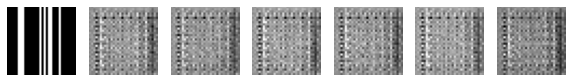

Epoch 31 gen_loss=1.052 disc_loss=0.481 real_acc=0.98 fake_acc=1.0
Epoch 32 gen_loss=1.043 disc_loss=0.471 real_acc=1.0 fake_acc=1.0
Epoch 33 gen_loss=1.053 disc_loss=0.472 real_acc=0.98 fake_acc=1.0
Epoch 34 gen_loss=1.029 disc_loss=0.487 real_acc=0.98 fake_acc=1.0
Epoch 35 gen_loss=1.039 disc_loss=0.478 real_acc=0.96 fake_acc=1.0
Epoch 36 gen_loss=1.081 disc_loss=0.454 real_acc=1.0 fake_acc=1.0
Epoch 37 gen_loss=1.082 disc_loss=0.466 real_acc=1.0 fake_acc=1.0
Epoch 38 gen_loss=1.103 disc_loss=0.460 real_acc=1.0 fake_acc=1.0
Epoch 39 gen_loss=1.126 disc_loss=0.465 real_acc=0.9 fake_acc=1.0
Epoch 40 gen_loss=1.164 disc_loss=0.453 real_acc=0.94 fake_acc=1.0


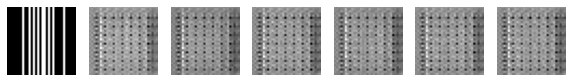

Epoch 41 gen_loss=1.215 disc_loss=0.437 real_acc=0.96 fake_acc=1.0
Epoch 42 gen_loss=1.240 disc_loss=0.430 real_acc=0.96 fake_acc=1.0
Epoch 43 gen_loss=1.291 disc_loss=0.431 real_acc=0.9 fake_acc=1.0
Epoch 44 gen_loss=1.281 disc_loss=0.432 real_acc=0.96 fake_acc=1.0
Epoch 45 gen_loss=1.326 disc_loss=0.409 real_acc=0.98 fake_acc=1.0
Epoch 46 gen_loss=1.318 disc_loss=0.421 real_acc=0.92 fake_acc=1.0
Epoch 47 gen_loss=1.336 disc_loss=0.415 real_acc=0.96 fake_acc=1.0
Epoch 48 gen_loss=1.317 disc_loss=0.403 real_acc=0.96 fake_acc=1.0
Epoch 49 gen_loss=1.288 disc_loss=0.414 real_acc=0.98 fake_acc=1.0
Epoch 50 gen_loss=1.270 disc_loss=0.417 real_acc=0.94 fake_acc=1.0


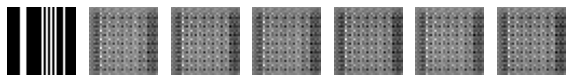

Epoch 51 gen_loss=1.222 disc_loss=0.410 real_acc=0.96 fake_acc=1.0
Epoch 52 gen_loss=1.212 disc_loss=0.394 real_acc=0.98 fake_acc=1.0
Epoch 53 gen_loss=1.206 disc_loss=0.404 real_acc=0.94 fake_acc=1.0
Epoch 54 gen_loss=1.202 disc_loss=0.394 real_acc=0.96 fake_acc=1.0
Epoch 55 gen_loss=1.220 disc_loss=0.379 real_acc=1.0 fake_acc=1.0
Epoch 56 gen_loss=1.273 disc_loss=0.401 real_acc=0.96 fake_acc=1.0
Epoch 57 gen_loss=1.357 disc_loss=0.386 real_acc=0.9 fake_acc=1.0
Epoch 58 gen_loss=1.419 disc_loss=0.366 real_acc=0.96 fake_acc=1.0
Epoch 59 gen_loss=1.437 disc_loss=0.378 real_acc=0.9 fake_acc=1.0
Epoch 60 gen_loss=1.499 disc_loss=0.362 real_acc=0.86 fake_acc=1.0


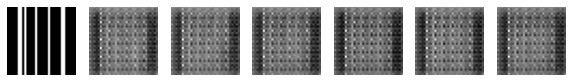

Epoch 61 gen_loss=1.517 disc_loss=0.357 real_acc=0.88 fake_acc=1.0
Epoch 62 gen_loss=1.549 disc_loss=0.342 real_acc=0.92 fake_acc=1.0
Epoch 63 gen_loss=1.544 disc_loss=0.342 real_acc=0.9 fake_acc=1.0
Epoch 64 gen_loss=1.467 disc_loss=0.333 real_acc=0.9 fake_acc=1.0
Epoch 65 gen_loss=1.443 disc_loss=0.316 real_acc=0.98 fake_acc=1.0
Epoch 66 gen_loss=1.442 disc_loss=0.329 real_acc=0.96 fake_acc=1.0
Epoch 67 gen_loss=1.404 disc_loss=0.298 real_acc=0.98 fake_acc=1.0
Epoch 68 gen_loss=1.382 disc_loss=0.310 real_acc=0.96 fake_acc=1.0
Epoch 69 gen_loss=1.480 disc_loss=0.271 real_acc=1.0 fake_acc=1.0
Epoch 70 gen_loss=1.506 disc_loss=0.273 real_acc=0.98 fake_acc=1.0


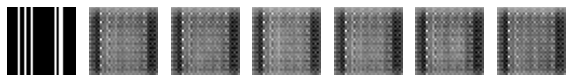

Epoch 71 gen_loss=1.540 disc_loss=0.260 real_acc=0.98 fake_acc=1.0
Epoch 72 gen_loss=1.592 disc_loss=0.253 real_acc=1.0 fake_acc=1.0
Epoch 73 gen_loss=1.736 disc_loss=0.239 real_acc=0.96 fake_acc=1.0
Epoch 74 gen_loss=1.753 disc_loss=0.227 real_acc=1.0 fake_acc=1.0
Epoch 75 gen_loss=1.802 disc_loss=0.231 real_acc=0.96 fake_acc=1.0
Epoch 76 gen_loss=1.799 disc_loss=0.244 real_acc=0.96 fake_acc=1.0
Epoch 77 gen_loss=1.752 disc_loss=0.222 real_acc=1.0 fake_acc=1.0
Epoch 78 gen_loss=1.728 disc_loss=0.230 real_acc=0.94 fake_acc=1.0
Epoch 79 gen_loss=1.705 disc_loss=0.218 real_acc=0.98 fake_acc=1.0
Epoch 80 gen_loss=1.679 disc_loss=0.198 real_acc=1.0 fake_acc=1.0


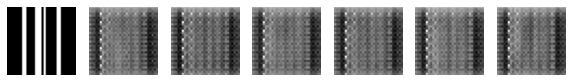

Epoch 81 gen_loss=1.686 disc_loss=0.190 real_acc=1.0 fake_acc=1.0
Epoch 82 gen_loss=1.698 disc_loss=0.217 real_acc=1.0 fake_acc=1.0
Epoch 83 gen_loss=1.703 disc_loss=0.204 real_acc=0.98 fake_acc=1.0
Epoch 84 gen_loss=1.755 disc_loss=0.213 real_acc=0.98 fake_acc=1.0
Epoch 85 gen_loss=1.864 disc_loss=0.206 real_acc=0.98 fake_acc=1.0
Epoch 86 gen_loss=1.881 disc_loss=0.186 real_acc=1.0 fake_acc=1.0
Epoch 87 gen_loss=1.874 disc_loss=0.183 real_acc=1.0 fake_acc=1.0
Epoch 88 gen_loss=1.913 disc_loss=0.185 real_acc=0.98 fake_acc=1.0
Epoch 89 gen_loss=1.920 disc_loss=0.190 real_acc=1.0 fake_acc=1.0
Epoch 90 gen_loss=1.825 disc_loss=0.192 real_acc=0.98 fake_acc=1.0


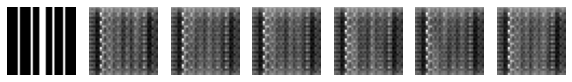

Epoch 91 gen_loss=1.821 disc_loss=0.193 real_acc=1.0 fake_acc=1.0
Epoch 92 gen_loss=1.825 disc_loss=0.191 real_acc=1.0 fake_acc=1.0
Epoch 93 gen_loss=1.825 disc_loss=0.175 real_acc=1.0 fake_acc=1.0
Epoch 94 gen_loss=1.806 disc_loss=0.180 real_acc=1.0 fake_acc=1.0
Epoch 95 gen_loss=1.779 disc_loss=0.175 real_acc=1.0 fake_acc=1.0
Epoch 96 gen_loss=1.860 disc_loss=0.176 real_acc=1.0 fake_acc=1.0
Epoch 97 gen_loss=1.895 disc_loss=0.185 real_acc=1.0 fake_acc=1.0
Epoch 98 gen_loss=1.932 disc_loss=0.181 real_acc=1.0 fake_acc=1.0
Epoch 99 gen_loss=1.984 disc_loss=0.154 real_acc=1.0 fake_acc=1.0
Epoch 100 gen_loss=2.000 disc_loss=0.166 real_acc=0.98 fake_acc=1.0


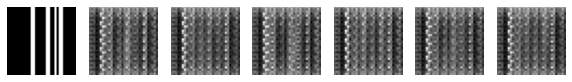

Epoch 101 gen_loss=1.970 disc_loss=0.154 real_acc=1.0 fake_acc=1.0
Epoch 102 gen_loss=1.994 disc_loss=0.154 real_acc=1.0 fake_acc=1.0
Epoch 103 gen_loss=2.018 disc_loss=0.152 real_acc=1.0 fake_acc=1.0
Epoch 104 gen_loss=2.032 disc_loss=0.166 real_acc=0.98 fake_acc=1.0
Epoch 105 gen_loss=2.008 disc_loss=0.141 real_acc=1.0 fake_acc=1.0


KeyboardInterrupt: 

In [14]:
epochs = 1000
for epoch in range(epochs):
    # take some random samples
    new_samples = sample_from_dataset(50,samples)
    # perform one training step (epoch)
    do_step(new_samples)
    if epoch % 10 == 0:
        show_results(epoch)
print("Done")

In [ ]:
nph = np.array(history)

plt.plot(nph[:,0], label='g-loss')
plt.plot(nph[:,1], label='d-loss')
plt.legend()
plt.show()

In [ ]:
nph = np.array(history)

plt.plot(nph[:,2], label='acc-real')
plt.plot(nph[:,3], label='acc-fake')
plt.show()

In [16]:
1e-3

0.001